In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
from decifer.decifer_dataset import DeciferDataset
from periodictable import elements as pelements

from decifer.utility import (
    extract_space_group_symbol,
    space_group_symbol_to_number,
)

def element_to_atomic_number(element):
    try:
        return pelements.symbol(element).number
    except KeyError:
        print(f"Invalid element symbol: {element}")
        return None

def space_group_to_crystal_system(space_group):

    try:
        if 1 <= space_group <= 2:
            return 1  # Triclinic
        elif 3 <= space_group <= 15:
            return 2  # Monoclinic
        elif 16 <= space_group <= 74:
            return 3  # Orthorhombic
        elif 75 <= space_group <= 142:
            return 4  # Tetragonal
        elif 143 <= space_group <= 167:
            return 5  # Trigonal
        elif 168 <= space_group <= 194:
            return 6  # Hexagonal
        elif 195 <= space_group <= 230:
            return 7  # Cubic
        else:
            return 0
    except:
        return 0

class DatasetAnalyzer:
    def __init__(self, dataset_path, fields, debug_max=None):
        self.dataset = DeciferDataset(dataset_path, fields)
        self.debug_max = debug_max
        self.lengths = []
        self.spacegroups = []
        self.spacegroups_num = []
        self.atomic = []
        self.atomic_num = []

    def analyze_lengths(self):
        for i, item in tqdm(enumerate(self.dataset), total=len(self.dataset) if self.debug_max is None else self.debug_max):
            self.lengths.append(len(item['cif_tokenized']))
            self.spacegroups.append(item['spacegroup'])
            spg_num = space_group_symbol_to_number(extract_space_group_symbol(item['cif_string']))
            if spg_num is not None:
                self.spacegroups_num.append(spg_num)
            # TODO None types are weird.
            atomic_elements = list(item['species'].split('"')[1::2])
            self.atomic.extend(atomic_elements)
            self.atomic_num.extend([element_to_atomic_number(e) for e in atomic_elements])

            if self.debug_max and i + 1 >= self.debug_max:
                break
        return self.lengths, self.spacegroups

    def compute_statistics(self):
        max_length = max(self.lengths)
        mean_length = np.mean(self.lengths)
        median_length = np.median(self.lengths)
        return max_length, mean_length, median_length

    def plot_distributions(self, threshold=500, bins=30):
        max_length, mean_length, median_length = self.compute_statistics()
        density = gaussian_kde(self.lengths)
        x_vals = np.linspace(min(self.lengths), max(self.lengths), 500)
        density_vals = density(x_vals)

        fig, ax = plt.subplots(figsize=(14, 5))

        # Histogram with Density Plot
        ax.hist(self.lengths, bins=bins, label='Histogram')
        # ax.plot(x_vals, density_vals * len(self.lengths) * np.diff(np.histogram(self.lengths, bins=bins)[1])[0], label='Estimated Density', color='red', linewidth=2)
        ax.axvline(max_length, color='orange', linestyle='--', label=f'Max: {max_length}')
        ax.axvline(mean_length, color='green', linestyle='--', label=f'Mean: {mean_length:.2f}')
        ax.axvline(median_length, color='blue', linestyle='--', label=f'Median: {median_length:.2f}')
        ax.set_title('Distribution of cif_tokenized Lengths')
        ax.set_xlabel('Length')
        ax.set_ylabel('Frequency (log-scale)')
        ax.legend()
        ax.grid(axis='y', alpha=0.2)
        ax.set_yscale('log')
        
        fig, ax = plt.subplots(figsize=(14, 5))

        ax.hist(np.array(self.spacegroups_num) - 0.5, edgecolor='black', bins=230)
        ax.set_title(f"Spacegroup Distribution")
        ax.set_xlabel("Spacegroup")
        ax.set_ylabel("Frequency")
        ax.grid(axis='y', alpha=0.2)
        ax.set_xticks(np.arange(1,231, 10))
        ax.set_xticklabels(np.arange(1,231, 10))
        
        fig, ax = plt.subplots(figsize=(14, 5))

        ax.hist(np.array(self.atomic_num) - 0.5, edgecolor='black', bins=max(self.atomic_num))
        ax.set_title(f"Atomic Number distribution")
        ax.set_xlabel("Atomic Number")
        ax.set_ylabel("Frequency")
        ax.grid(axis='y', alpha=0.2)
        ax.set_xticks(np.arange(1,max(self.atomic_num), 10))
        ax.set_xticklabels(np.arange(1,max(self.atomic_num), 10))

        fig, ax = plt.subplots(figsize=(14, 5))

        # Spacegroup Distribution for Lengths > Threshold
        over_threshold_spacegroups = [sg for length, sg in zip(self.lengths, self.spacegroups) if length > threshold]
        spacegroup_counts = Counter(over_threshold_spacegroups)
        spacegroup_labels, spacegroup_frequencies = zip(*sorted(spacegroup_counts.items(), key=lambda x: x[1], reverse=True))

        ax.bar(spacegroup_labels, spacegroup_frequencies, edgecolor='black')
        ax.set_title(f"Spacegroup Distribution (Lengths > {threshold})", fontsize=16)
        ax.set_xlabel("Spacegroup")
        ax.set_ylabel("Frequency")
        ax.grid(axis='y', alpha=0.2)
        ax.tick_params(axis='x', labelrotation=90)

        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

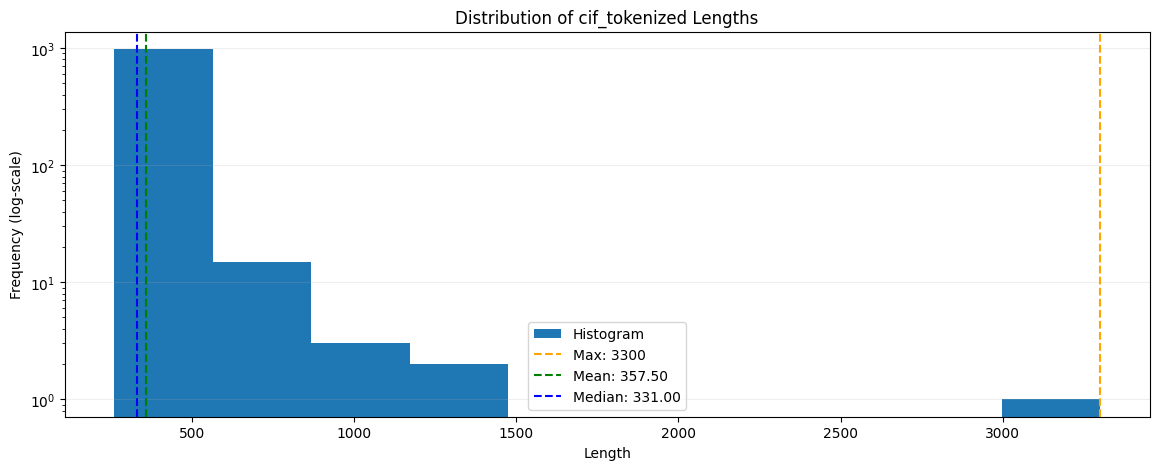

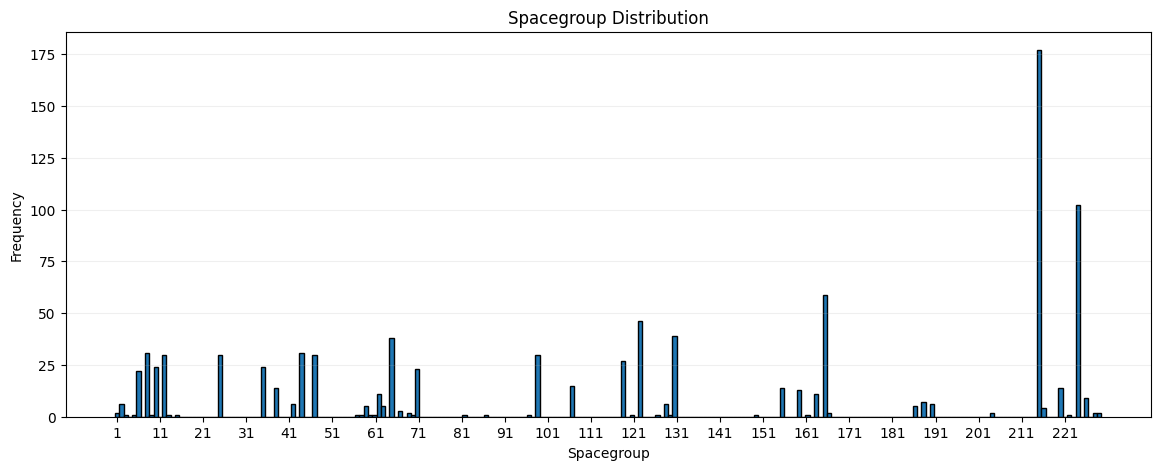

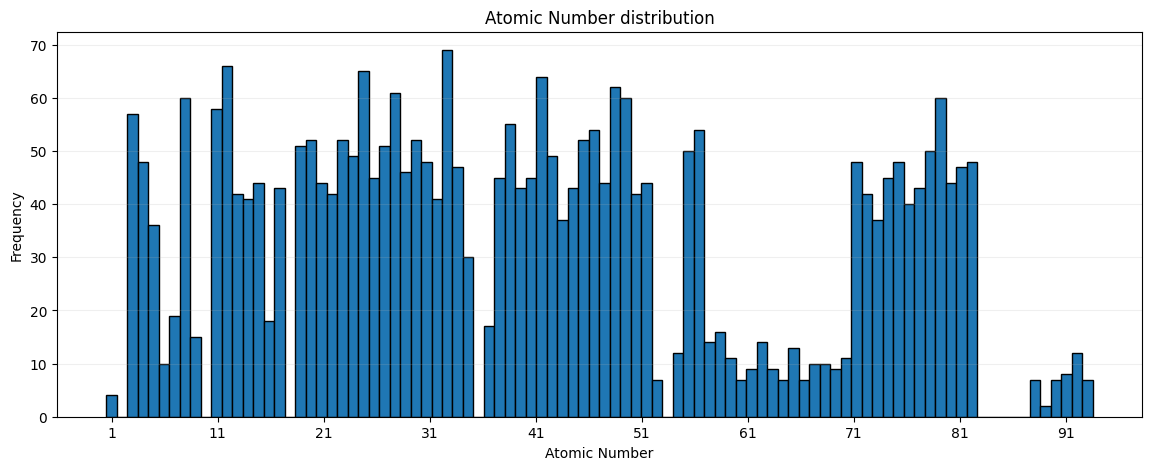

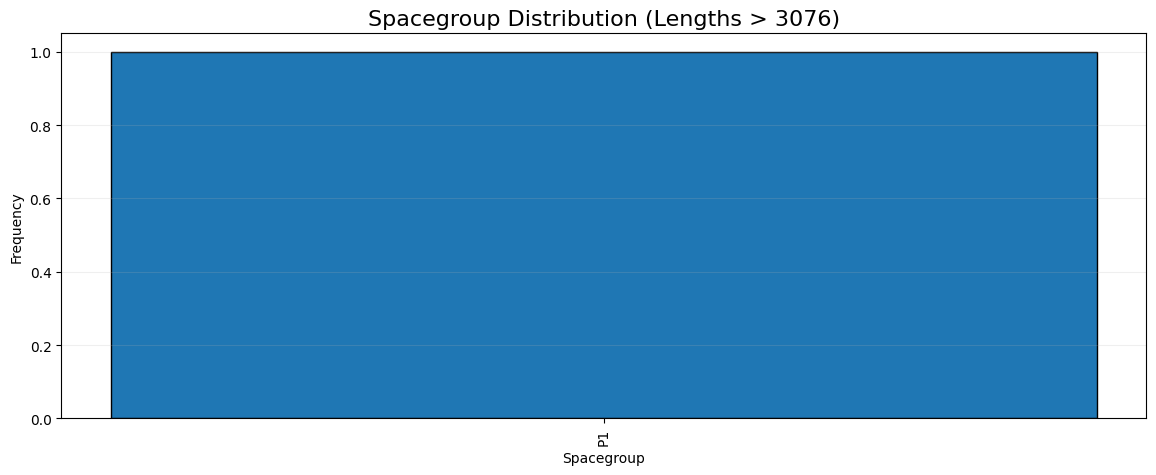

In [8]:

# Usage Example:
if __name__ == "__main__":
    dataset_path = '../data/crystallm/full/serialized/test.h5'
    fields = ['cif_string', 'cif_tokenized', 'species', 'spacegroup', 'xrd_disc.q', 'xrd_disc.iq']
    analyzer = DatasetAnalyzer(dataset_path, fields, debug_max=1000)
    analyzer.analyze_lengths()
    analyzer.plot_distributions(threshold=3076, bins=10)
